In [77]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sns.set()

<p>We will be conducting an analysis of the following parameters' prediction value of a stock rising or falling in value on the following day of the observed parameters. 
<ul>
<li>Lag 1-5</li>
<li>current day open</li>
<li>100d mav</li>
<li>50d mav</li>
<li>30d mav</li>
<li>10d mav</li>
<li>30d high</li>
<li>20d high</li>
<li>10d high</li>
<li>5d high</li>
<li><del>SMP500 index</del></li>
<li><del>DOW Jones</del></li>
<li><del>Nasdaq</del></li>
</ul>

our testing data will be Tesla stock from Jan3, 2017 - Jan3, 2020, and our training data will be Tesla stock from Jan3, 2011 - Jan3, 2017.
</p>


<p>Using a KNN classifier, we can classify our data into either rising or falling in value on the following day (Class 1, or Class 0). 
<br><br>a KNN classifier stores all of the training data and the parameters associated with each observation. Then, when the model is trying to classify a new point, the classifier finds the K closest observations to the new observation using euclidian distance, and votes for the most frequent class that appears in these nearest neighbors. 
<br><br>we believe that a KNN classifier may be a decent way to classify our data, because if a stock is in a similar position to how it was in the past, it is likely for it to behave the same. We can take advantage of this by buyidling a KNN classifier

we start by building the classes for our test and train data and cleaning our data.

In [78]:
df = pd.read_csv('TSLA.csv', index_col=0)
df.index = pd.to_datetime(df.index)

#create classes, and shift data back one (yesterdays parameters should predict today's outcome)
df['Class'] = (df['Close']-df['Open'] > 0).mul(1).shift(-1)
df.dropna(inplace=True)

#create Lag in dataframe which will tell the nth last class
for i in range(1, 6):
    df['Lag{}'.format(i)] = df['Class'].shift(i)


df['100mav']= df['Close'].shift(1).rolling(100).mean()
df['50mav'] = df['Close'].shift(1).rolling(50).mean()
df['30mav'] = df['Close'].shift(1).rolling(30).mean()
df['10mav'] = df['Close'].shift(1).rolling(10).mean()
df['30d_high'] = df['Close'].shift(1).rolling(30).max()
df['20d_high'] = df['Close'].shift(1).rolling(20).max()
df['10d_high'] = df['Close'].shift(1).rolling(10).max()
df['5d_high'] = df['Close'].shift(1).rolling(5).max()
# df.head(20)

df.dropna(inplace=True)

Now that we have properly formed our parameters, and cleaned our data we can look at how these parameters may correlate with our categories

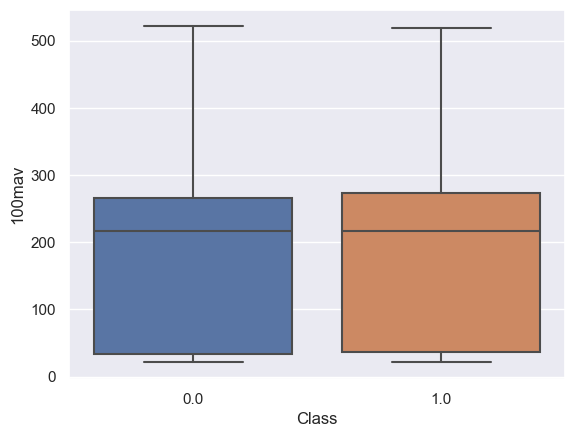

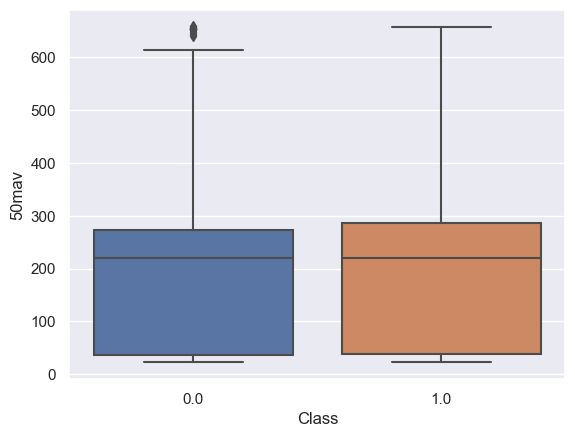

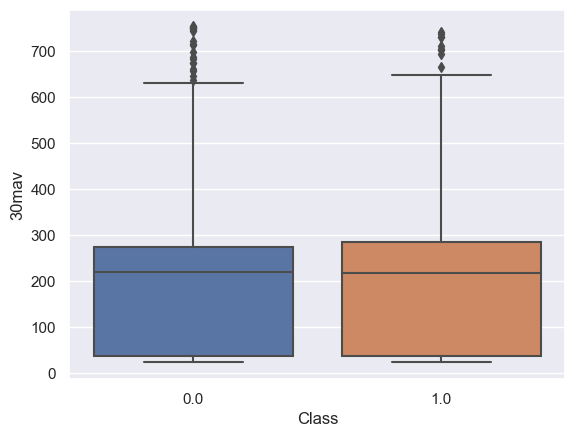

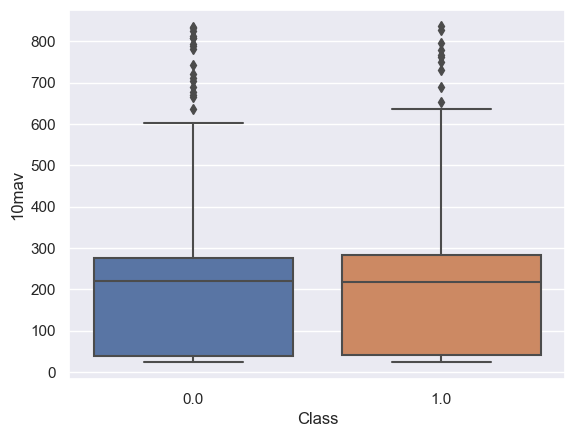

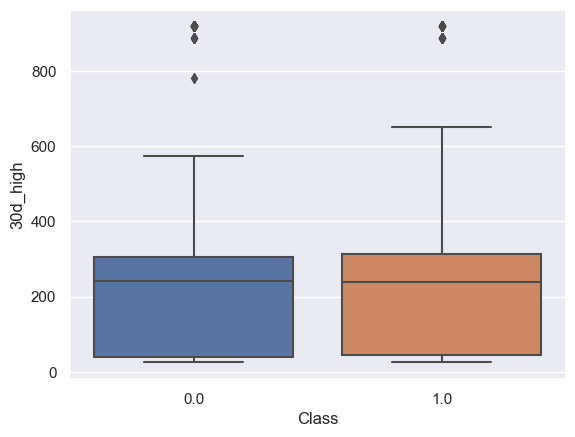

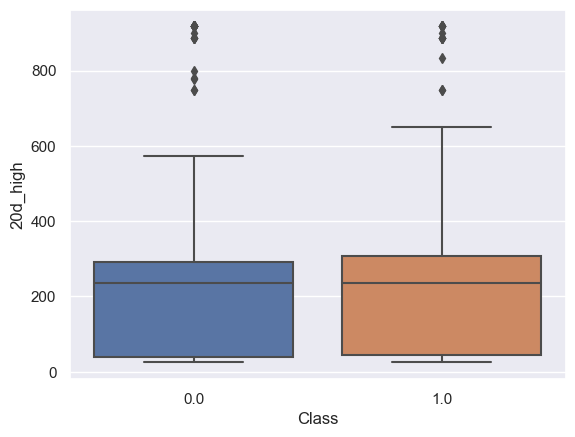

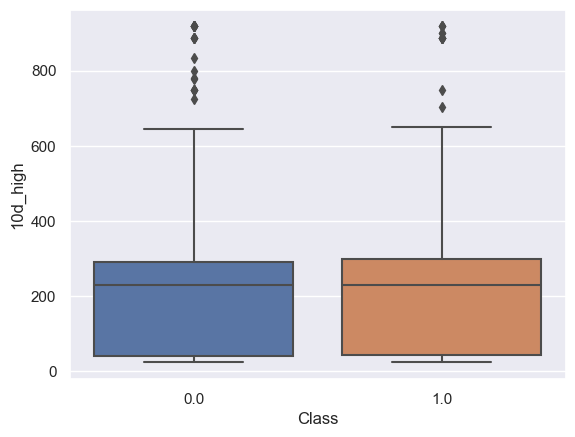

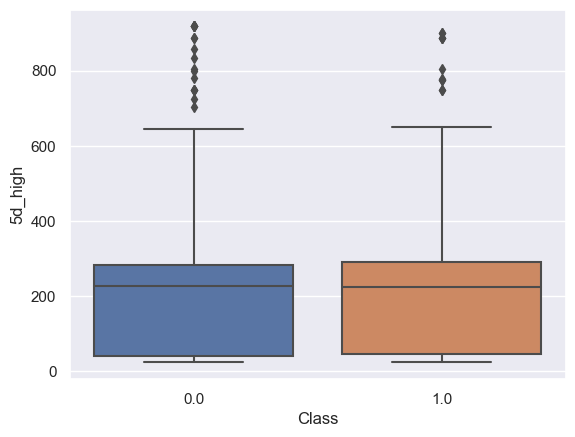

In [79]:
parameters = df.loc[:,'100mav':]

for param in parameters.columns:
    sns.boxplot(x=df['Class'], y=df[param])
    plt.show()
parameters = df.loc[:,'Lag1':]

So far, our parameters seem to have low predictive value on the classification of our chosen class. We will split our data into train and test, and continue with a KNN Classifier and a forwards subset selection on our data. 

In [80]:
X_train, X_test, y_train, y_test = train_test_split(parameters, df['Class'], test_size=0.33, random_state=0)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)


0.4588688946015424

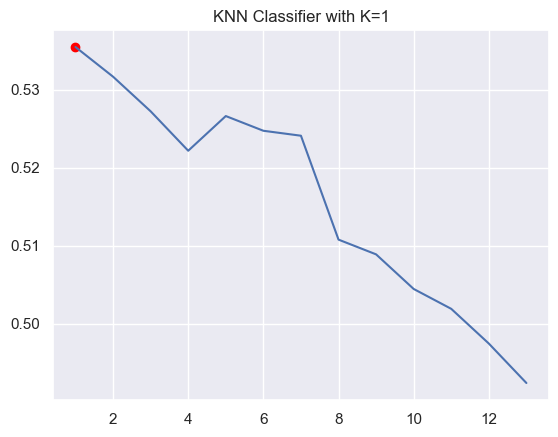

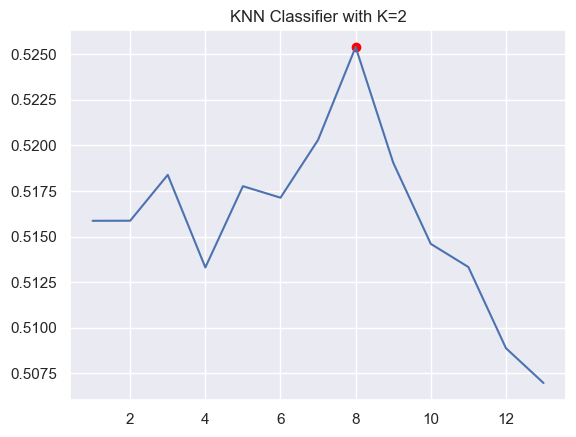

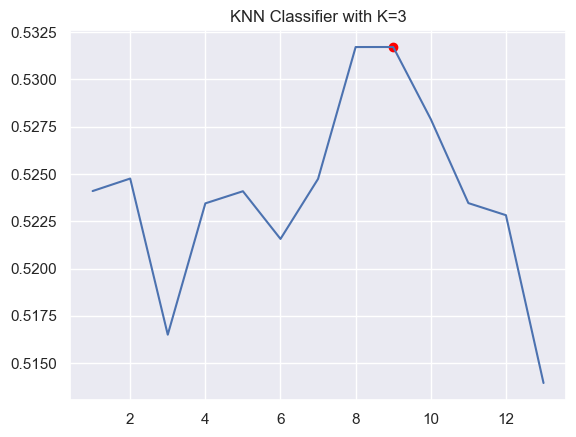

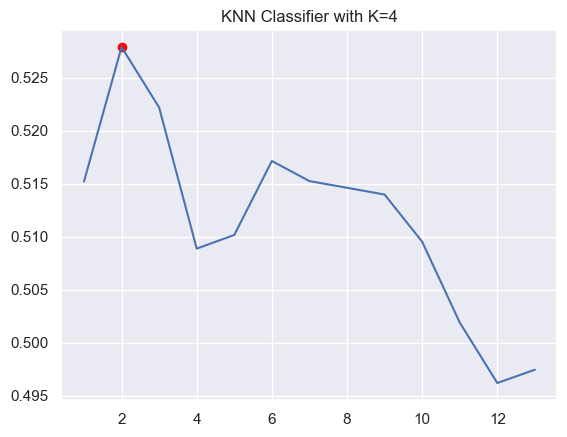

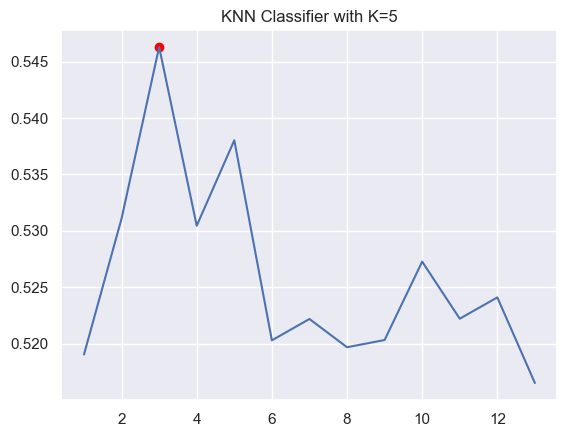

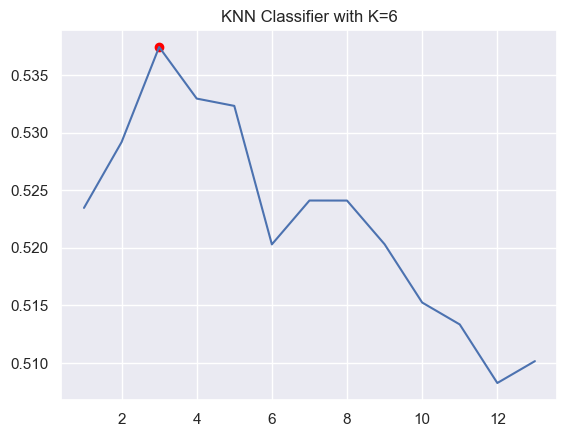

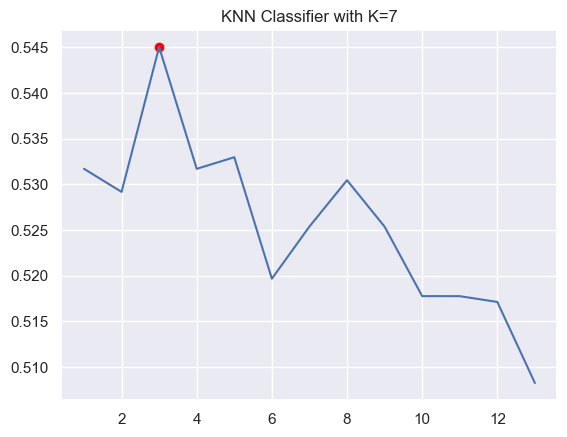

In [112]:
best_scores = []
best_subsets = []
for i in range(1, 8):
    knn = KNeighborsClassifier(n_neighbors=i)
    sfs1 = SFS(knn, k_features=len(parameters.columns), forward=True, floating=False, cv=5)
    sfs1=sfs1.fit(X_train,y_train)
    forward = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
    plt.plot(forward.index, forward['avg_score'])
    plt.scatter(np.argmax(forward['avg_score'].values)+1, max(forward['avg_score']), c='red')
    plt.title('KNN Classifier with K={}'.format(i))
    plt.show()
    best_scores.append([np.argmax(forward['avg_score']), max(forward['avg_score'])])
    best_subsets.append(forward['feature_names'].iloc[np.argmax(forward['avg_score'])])

In [115]:
# forward['feature_names'].loc[np.argmax(forward['avg_score'])]
forward
forward['feature_names'].iloc[0]
print(best_scores,best_subsets)

[[0, 0.535483222824995], [7, 0.5253827606992164], [8, 0.5317058468957203], [1, 0.5278902953586498], [2, 0.5462929475587703], [2, 0.5374402250351616], [2, 0.5450391802290537]] [('50mav',), ('Lag1', 'Lag2', 'Lag4', 'Lag5', '30mav', '30d_high', '20d_high', '5d_high'), ('Lag2', 'Lag3', 'Lag4', 'Lag5', '30mav', '10mav', '30d_high', '10d_high', '5d_high'), ('Lag4', '50mav'), ('Lag1', 'Lag3', '5d_high'), ('Lag1', 'Lag3', '5d_high'), ('Lag1', 'Lag3', '5d_high')]


We can see from our test of diferent K values, adn our tests of different parameters with forwards subset selection that the best value of K was K=7, and the best number of parametsr was 3 parameters. These parameters were Lag1, Lag3, 5d_high.


now that we have the ideal k and parameters for our model, let's see how it matches up to the test data.

In [117]:
final_params_X_test = X_test[['Lag1', 'Lag3', '5d_high']]
final_params_X_train = X_train[['Lag1', 'Lag3', '5d_high']]
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(final_params_X_train, y_train)
knn.score(final_params_X_test, y_test)


0.4884318766066838

We can judge from the end accuracy value that a cross validation of the knn method with train and test data did not perform very well. We can conclude that either the parameters we chose were not a good indication of the underlying model, or the KNN Classifier does not provide a good fit for this model. 